# 2022 Comparative analysis benchmark

Logbook: https://docs.google.com/document/d/1NsqY_mA7U-jY2aLQlaQimiNLaRvYVx26cAia8HTdG_M/edit#


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display
import pandas as pd

import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import scipy as sp
import os, re
import glob
from tqdm.auto import tqdm
import tempfile
from itertools import product


In [2]:
# MODIFICATIONS = [
#     'H3K4me2', 'H3K4me3', 'H3K9ac' 'H3K27ac', # narrow
#     'H3K4me1', 'H3K9me3', 'H3K27me3', 'H3K36me3', 'H3K79me2', # broad
#     'H3K4ac', 'H3K56ac', 'H3K79me1' # mixed
# ]

# Core histone marks
MODIFICATIONS = [
    'H3K4me3', 'H3K4me1', 'H3K27me3', 'H3K36me3'
]

PATH = os.path.expanduser('~/data/2022_comparative_analysis')
FIGURES_DIR = os.path.join(PATH, 'pics')
EXT = 'pdf'
! mkdir -p {FIGURES_DIR}

In [3]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

## MACS2

In [4]:
MACS2_FOLDER = f'{PATH}/macs2'
MACS2_LEVELS = ['q0.05', 'broad0.1']

dfm = pd.DataFrame(columns=['modification', 'replicate', 'level', 'file', 'peaks'], dtype=object)
for file in tqdm(glob.glob(MACS2_FOLDER + '/*.*Peak')):
    if 'gapped' in file:
        continue
    level = next((l for l in MACS2_LEVELS if f'_{l}' in file), None)
    modification = next((m for m in MODIFICATIONS if f'_{m}' in file), None)
    if level and modification:
        replicate = os.path.basename(file).replace(f'H1_{modification}_', '')[:3]
        peaks = lines(file)
        dfm.loc[len(dfm)] = (modification, replicate, f'macs2 {level}', file, peaks)

  0%|          | 0/111 [00:00<?, ?it/s]

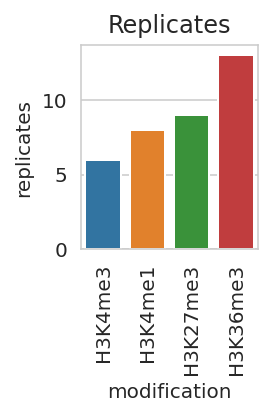

In [5]:
t = (dfm.groupby(['modification'])['file'].count() / len(MACS2_LEVELS)).astype(int)
plt.figure(figsize=(2, 3))
sns.barplot(data=pd.DataFrame(dict(modification=t.index, replicates=t)), x='modification', y='replicates',
            order=MODIFICATIONS)
plt.xticks(rotation=90)
plt.title('Replicates')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'replicates_macs2.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

In [6]:
macs2levels2process = {'macs2 q0.05', 'macs2 broad0.1'}

## SICER

In [7]:
SICER_FOLDER = f'{PATH}/sicer'
SICER_LEVELS = ['FDR0.01']

dfsc = pd.DataFrame(columns=['modification', 'replicate', 'level', 'file', 'peaks'], dtype=object)
for file in tqdm(glob.glob(SICER_FOLDER + '/*islands-summary*')):
    level = next((l for l in SICER_LEVELS if f'-{l}' in file), None)
    modification = next((m for m in MODIFICATIONS if f'_{m}' in file), None)
    if level and modification:
        replicate = os.path.basename(file).replace(f'H1_{modification}_', '')[:3]
        peaks = lines(file)
        dfsc.loc[len(dfsc)] = (modification, replicate, f'sicer {level}', file, peaks)

  0%|          | 0/37 [00:00<?, ?it/s]

In [8]:
sicerlevels2process = {'sicer FDR0.01'}

## SPAN

In [43]:
SPAN_FOLDER = f'{PATH}/span'
GAPS = [0]
FDRS = ['0.05']

dfs = pd.DataFrame(columns=['modification', 'replicate', 'level', 'fdr', 'gap', 'file', 'peaks'], dtype=object)
for file in tqdm(glob.glob(SPAN_FOLDER + '/*.peak')):
    if 'Input' in file:
        continue
    
    modification = next((m for m in MODIFICATIONS if f'_{m}' in file), None)
    fdr = next((f for f in FDRS if f'_{f}_' in file), None)
    gap = next((g for g in GAPS if f'_{g}.' in file), None)
    if modification and fdr is not None and gap is not None:
        level = f'span 200_{fdr}_{gap}' 
        replicate = os.path.basename(file).replace(f'H1_{modification}_', '')[:3]
        peaks = lines(file)
        dfs.loc[len(dfs)] = (modification, replicate, level, fdr, gap, file, peaks)

  0%|          | 0/37 [00:00<?, ?it/s]

In [44]:
spanlevels2process = {'span 200_0.05_0'}

## Summary

In [45]:
dfa = pd.concat([
    dfm.loc[[l in macs2levels2process for l in dfm['level']]],
    dfs.loc[[l in spanlevels2process for l in dfs['level']]],
    dfsc.loc[[l in sicerlevels2process for l in dfsc['level']]],
]).reset_index(drop=True)

dfa['name'] = ''
dfa.loc[dfa['level'] == 'macs2 q0.05', 'name'] = 'MACS2'
dfa.loc[dfa['level'] == 'macs2 broad0.1', 'name'] = 'MACS2 broad'
dfa.loc[dfa['level'] == 'sicer FDR0.01', 'name'] = 'SICER'
dfa.loc[dfa['level'] == 'span 200_0.05_0', 'name'] = 'SPAN'
dfa.sample(5)

,modification,replicate,level,file,peaks,fdr,gap,name
1,H3K27me3,4_1,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,6995,NaN,NaN,MACS2 broad
142,H3K27me3,1_1,sicer FDR0.01,/home/jetbrains/data/2022_comparative_analysis...,18357,NaN,NaN,SICER
44,H3K36me3,1_1,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,42613,NaN,NaN,MACS2 broad
84,H3K36me3,3_1,span 200_0.05_0,/home/jetbrains/data/2022_comparative_analysis...,12711,0.05,0.0,SPAN
93,H3K36me3,2_2,span 200_0.05_0,/home/jetbrains/data/2022_comparative_analysis...,19733,0.05,0.0,SPAN


# Group analysis

In [46]:
def plot_data_cells(
        df, cid, value, description, bar=True, swarm=True, order=None, lower=None, upper=None, figx=None, figy=None
):
    cids = list(set(df[cid]))
    axs = {}
    total = len(cids) * len(MODIFICATIONS)
    plt.figure(figsize=(figx or int(total / 3), figy or 4))
    offset = 0
    for m in MODIFICATIONS:
        data = df.loc[df['modification'] == m].sort_values(by=[cid])
        w = len(cids)
        ax = plt.subplot2grid((1, total), (0, offset), colspan=w)

        if bar:
            sns.barplot(data=data,
                        x=cid, y=value,
                        capsize=.2, errwidth=2,
                        ax=ax,
                        order=order)
        else:
            sns.boxplot(data=data, x=cid, y=value, showfliers=False, ax=ax,
                        order=order)
        if swarm:
            sns.swarmplot(data=data,
                          x=cid, y=value,
                          size=4,
                          color="black",
                          alpha=0.8,
                          ax=ax,
                          order=order)

            # ax.legend().remove()
        axs[ax] = plt.ylim()
        if offset > 0:
            ax.get_yaxis().set_ticklabels([])
            ax.set_ylabel('')
        else:
            ax.set_ylabel(description)

        offset += w
        ax.set_xlabel('')
        ax.set_title(m)
        ax.xaxis.set_tick_params(rotation=90)

    ymin = np.min([v[0] for v in axs.values()])
    if lower is not None:
        ymin = max(ymin, lower)
    ymax = np.max([v[1] for v in axs.values()])
    if upper is not None:
        ymax = min(ymax, upper)

    for ax in axs.keys():
        ax.set_ylim(bottom=ymin, top=ymax)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{value}.{EXT}'), bbox_inches='tight', dpi=300)
    plt.show()


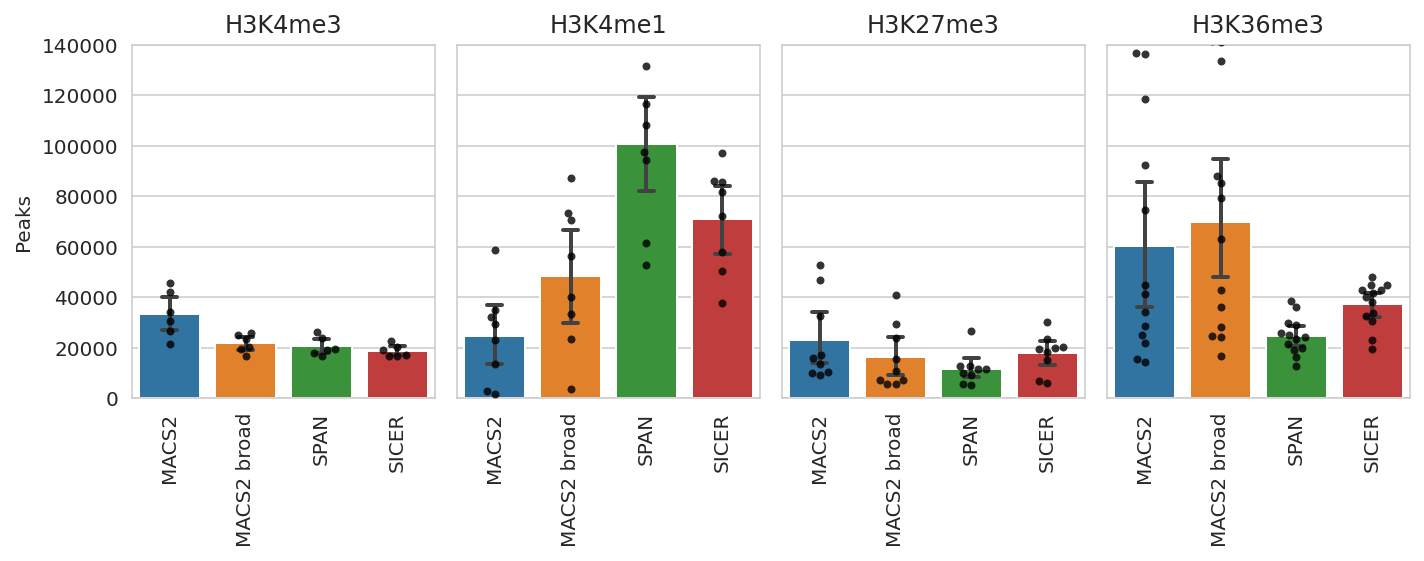

In [47]:
plot_data_cells(dfa, 'name', 'peaks', 'Peaks', upper=140_000, figx=10, figy=4,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])

In [48]:
dfa[(dfa['modification'] == 'H3K4me1') & (dfa['peaks']< 10000)]

# Filter out bad quality and super high quality data
dfa = dfa[~((dfa['modification'] == 'H3K4me1') & ((dfa['replicate'] == '1_1') |
                                                  (dfa['replicate'] == '1_2')))]
dfa = dfa[~((dfa['modification'] == 'H3K27me3') & (dfa['replicate'] == '1_1'))]
dfa = dfa[~((dfa['modification'] == 'H3K36me3') & ((dfa['replicate'] == '1_1') |
                                                  (dfa['replicate'] == '2_1')))]

dfa

,modification,replicate,level,file,peaks,fdr,gap,name
0,H3K36me3,4_2,macs2 q0.05,/home/jetbrains/data/2022_comparative_analysis...,28534,NaN,NaN,MACS2
1,H3K27me3,4_1,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,6995,NaN,NaN,MACS2 broad
2,H3K4me1,5_1,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,3553,NaN,NaN,MACS2 broad
3,H3K4me1,3_1,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,87050,NaN,NaN,MACS2 broad
4,H3K4me1,4_1,macs2 q0.05,/home/jetbrains/data/2022_comparative_analysis...,13398,NaN,NaN,MACS2
...,...,...,...,...,...,...,...,...
138,H3K36me3,4_2,sicer FDR0.01,/home/jetbrains/data/2022_comparative_analysis...,38246,NaN,NaN,SICER
139,H3K36me3,5_1,sicer FDR0.01,/home/jetbrains/data/2022_comparative_analysis...,44840,NaN,NaN,SICER
140,H3K4me3,1_1,sicer FDR0.01,/home/jetbrains/data/2022_comparative_analysis...,19069,NaN,NaN,SICER
141,H3K27me3,1_2,sicer FDR0.01,/home/jetbrains/data/2022_comparative_analysis...,20129,NaN,NaN,SICER


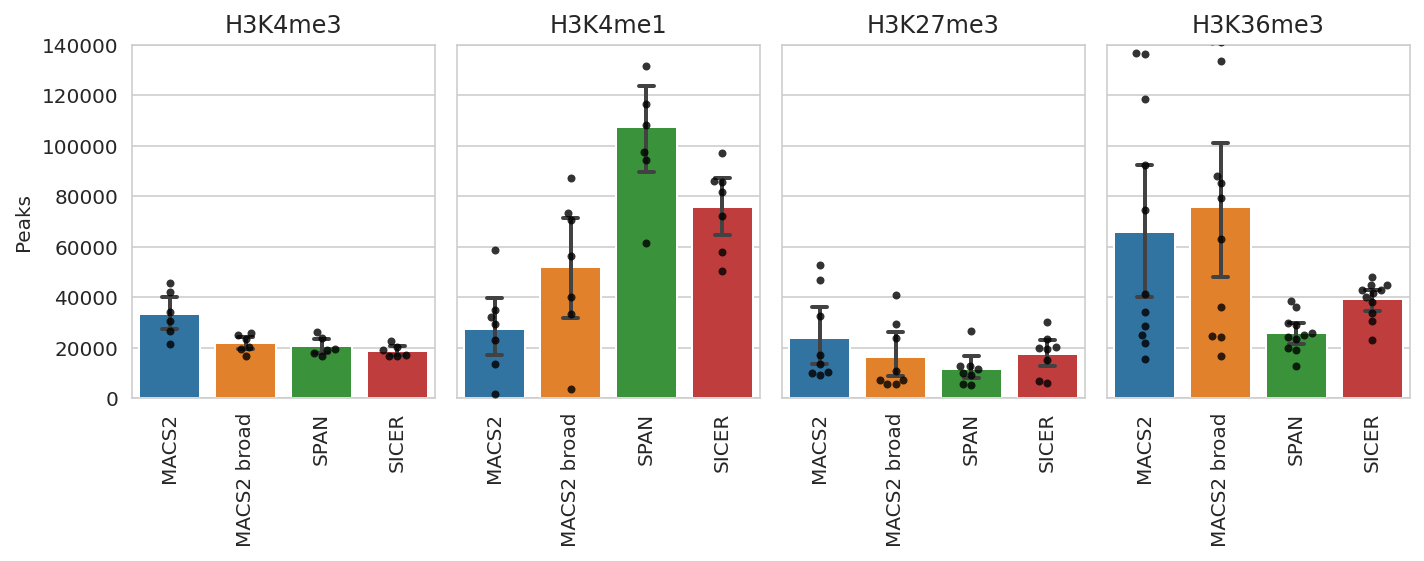

In [49]:
plot_data_cells(dfa, 'name', 'peaks', 'Peaks', upper=140_000, figx=10, figy=4,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])

In [50]:
ts = []
for modification, name, file in tqdm(zip(dfa['modification'], dfa['name'], dfa['file'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t['modification'] = modification
    t['name'] = name
    ts.append(t.sample(min(len(t), 10_000)))
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

0it [00:00, ?it/s]

,length,modification,name
574107,182,H3K4me3,MACS2
572749,602,H3K4me3,MACS2
383636,653,H3K4me3,MACS2 broad
465726,234,H3K27me3,MACS2
244464,380,H3K27me3,MACS2
964611,4199,H3K4me1,SICER
761818,1365,H3K36me3,SPAN
875799,3991,H3K27me3,SPAN
1183699,2399,H3K36me3,SICER
107438,241,H3K36me3,MACS2 broad


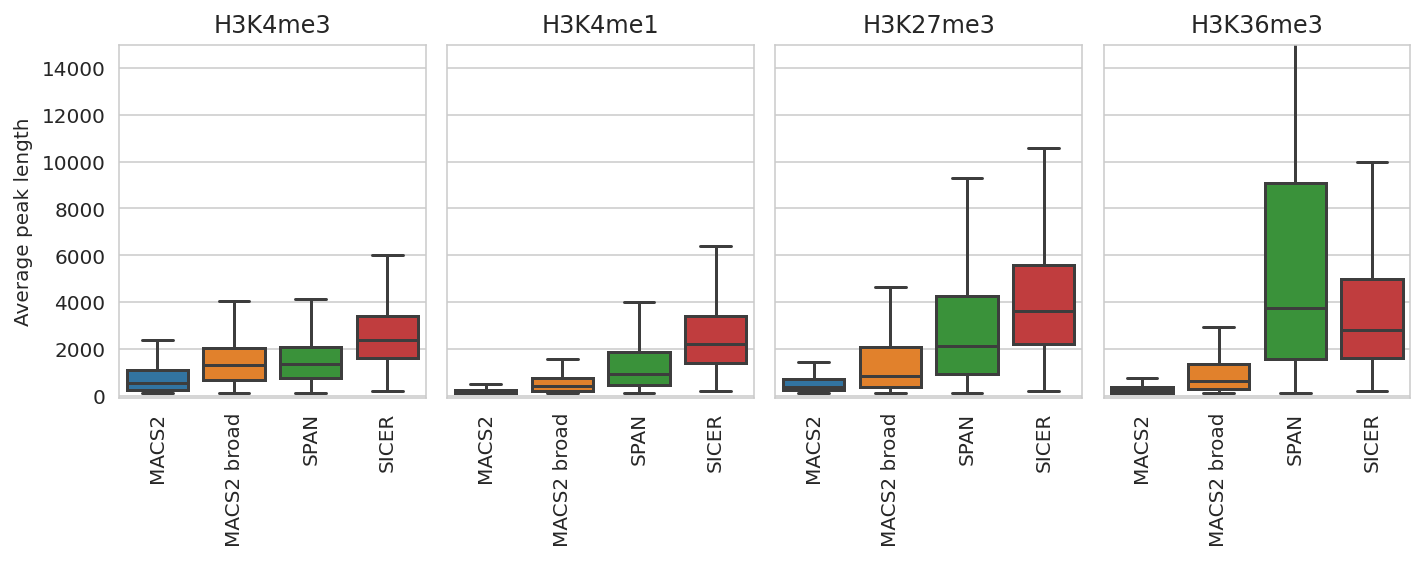

In [51]:
plot_data_cells(t, 'name', 'length', 'Average peak length', bar=False, swarm=False, 
                lower=-100, upper=15_000, figx=10, figy=4,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])

# Difference between tools

In [52]:
diff_df = pd.DataFrame(
    columns=['modification', 'replicate', 'name', 'peaks'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

tools = list(sorted(set(dfa['name'])))
for m in tqdm(MODIFICATIONS):
    print(m)
    tm = dfa.loc[dfa['modification'] == m]
    reps = list(sorted(set(tm['replicate'])))
    for rep in reps:
        for i in range(len(tools)):
            for j in range(i + 1, len(tools)):
                tool1, tool2 = tools[i], tools[j]
                if tool1 != 'SPAN' and tool2 != 'SPAN':
                    continue
                t1 = tm.loc[(tm['name'] == tool1) & (tm['replicate'] == rep)]
                t2 = tm.loc[(tm['name'] == tool2) & (tm['replicate'] == rep)]
                if len(t1) == 0 or len(t2) == 0:
                    continue
                name = f'{tool1} - {tool2}'
                file1 = sorted_file(t1['file'].values[0])
                file2 = sorted_file(t2['file'].values[0])
                tf = tempfile.mktemp()
                ! bedtools intersect -a {file1} -b {file2} -wa -v > {tf}
                peaks = lines(tf)
                diff_df.loc[len(diff_df)] = \
                    (m, rep, name, peaks)
diff_df.sample(5)

  0%|          | 0/4 [00:00<?, ?it/s]

H3K4me3
H3K4me1
H3K27me3
H3K36me3


,modification,replicate,name,peaks
62,H3K27me3,7_1,SICER - SPAN,6255
50,H3K27me3,4_1,SICER - SPAN,17783
46,H3K27me3,2_2,MACS2 broad - SPAN,705
52,H3K27me3,5_2,MACS2 broad - SPAN,9936
66,H3K36me3,3_1,MACS2 - SPAN,438


In [53]:
diff_dfa = pd.concat([diff_df, dfa[['modification', 'replicate', 'name', 'peaks']]]).reset_index(drop=True)
diff_dfa.sample(5)

,modification,replicate,name,peaks
186,H3K27me3,5_2,SPAN,9197
99,H3K4me1,3_1,MACS2 broad,87050
165,H3K4me3,1_1,SPAN,19239
43,H3K27me3,2_1,MACS2 broad - SPAN,859
46,H3K27me3,2_2,MACS2 broad - SPAN,705


In [ ]:
plot_data_cells(diff_dfa, 'name', 'peaks', 'Peaks', swarm=False, upper=140_000, figx=10, figy=4,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ])

# Jaccard between replicates

In [55]:
import tempfile

def compute_reps_overlap(df_peaks, modifications):
    reps_overlap = pd.DataFrame(columns=['modification', 'tool', 'rep1', 'rep2',
                                         'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                         'peaks1_overlap', 'peaks2_overlap', 'peaks_overlap_len'], dtype=object)

    tf = tempfile.mktemp()

    tools = df_peaks['name'].unique()
    for m in tqdm(modifications):
        print(m)
        tm = df_peaks[(df_peaks['modification'] == m)]
        reps = list(sorted(set(tm['replicate'])))
        for tool in tools:
            for i in range(len(reps)):
                for j in range(i + 1, len(reps)):
                    rep1, rep2 = reps[i], reps[j]
                    t1 = tm[(tm['name'] == tool) & (tm['replicate'] == rep1)]
                    t2 = tm[(tm['name'] == tool) & (tm['replicate'] == rep2)]
                    if len(t1) == 0 or len(t2) == 0:
                        continue
                    file1 = sorted_file(t1['file'].values[0])
                    file2 = sorted_file(t2['file'].values[0])
                    peaks1 = t1['peaks'].values[0]
                    peaks1_len = int(bedl(file1).sum())
                    peaks2 = t2['peaks'].values[0]
                    peaks2_len = int(bedl(file2).sum())
                    !bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
                    overlap1 = lines(tf)
                    !bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
                    overlap2 = lines(tf)
                    !bedtools intersect -a {file1} -b {file2} -wo > {tf}
                    overlap_len = int(last_col(tf).sum())

                    reps_overlap.loc[len(reps_overlap)] = \
                        (m, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                         overlap1, overlap2, overlap_len)
    reps_overlap['jaccard'] = [
        d(lo, l1 + l2 - lo)
        for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks_overlap_len'])
    ]
    return reps_overlap

In [56]:
reps_overlap = compute_reps_overlap(dfa, MODIFICATIONS)
reps_overlap.sample(5)

  0%|          | 0/4 [00:00<?, ?it/s]

H3K4me3
H3K4me1
H3K27me3
H3K36me3


,modification,tool,rep1,rep2,peaks1,peaks1_len,peaks2,peaks2_len,peaks1_overlap,peaks2_overlap,peaks_overlap_len,jaccard
220,H3K27me3,SPAN,4_1,6_1,12830,55080765,12819,54489957,9847,9962,42022610,0.622114
384,H3K36me3,SPAN,3_1,7_1,12711,124804350,38545,220831118,12257,12906,110343756,0.468966
288,H3K36me3,MACS2,4_2,6_1,28534,14883993,15549,6773586,7014,7428,2615566,0.137358
146,H3K27me3,MACS2,1_2,4_1,9262,4884409,13690,9664863,5934,5487,2564699,0.214000
120,H3K4me1,SPAN,4_3,5_1,97480,128303756,131549,208060034,74634,70834,97161077,0.406187


In [57]:
# TODO use melt() here!
ro = pd.DataFrame(columns=['Modification', 'Replicate', 'Tool', 'Overlap'], dtype=object)
for _, row in reps_overlap.iterrows():
    m = row['modification']
    tool = row['tool']
    rep1 = row['rep1']
    rep2 = row['rep2']
    peaks1 = row['peaks1']
    peaks2 = row['peaks2']
    overlap1 = row['peaks1_overlap']
    overlap2 = row['peaks1_overlap']
    ro.loc[len(ro)] = (m, f'{rep1} vs {rep2}', tool, d(overlap1, peaks1))
    ro.loc[len(ro)] = (m, f'{rep2} vs {rep1}', tool, d(overlap2, peaks2))
ro.sample(5)

,Modification,Replicate,Tool,Overlap
673,H3K36me3,6_1 vs 4_1,MACS2 broad,0.631951
261,H3K4me1,4_2 vs 3_1,SICER,0.720502
860,H3K36me3,2_2 vs 7_1,SICER,0.819214
138,H3K4me1,3_1 vs 5_1,MACS2,0.018205
477,H3K27me3,5_3 vs 2_1,SICER,0.285744


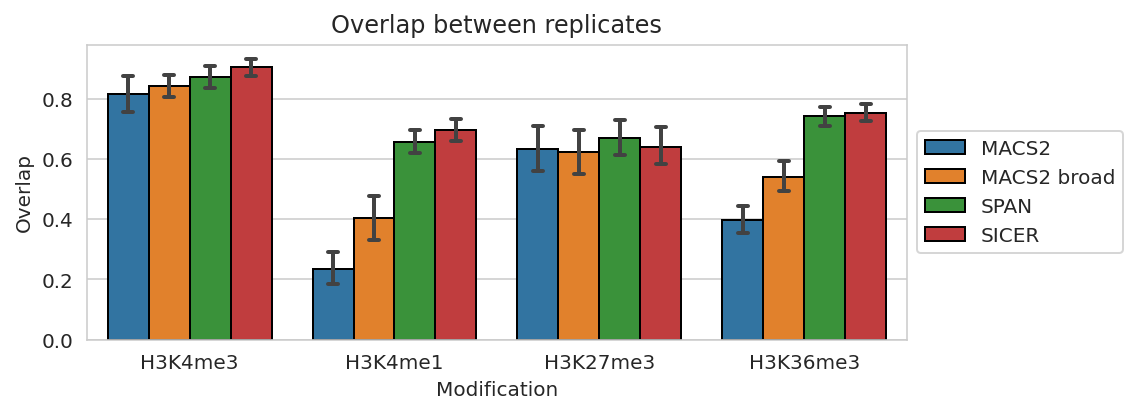

In [58]:
plt.figure(figsize=(8, 3))
plt.title(f'Overlap between replicates')
g_results = sns.barplot(data=ro, x='Modification', y='Overlap', hue='Tool',
                        capsize=.05, errwidth=2, edgecolor="black",
                        order=MODIFICATIONS,
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
# sns.boxplot(data=ro, x='Modification', y='Overlap', hue='Tool')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'overlap.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

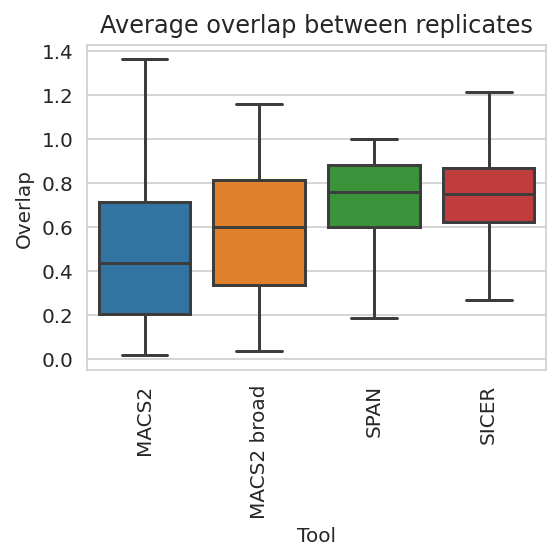

In [59]:
plt.figure(figsize=(4, 4))
plt.title(f'Average overlap between replicates')
g_results = sns.boxplot(data=ro, x='Tool', y='Overlap', showfliers=False,
                       order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
g_results.axes.xaxis.set_tick_params(rotation=90)
# Put a legend to the right of the current axis
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'overlap.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

In [60]:
rj = pd.DataFrame(columns=['Modification', 'Replicate', 'Tool', 'Jaccard'], dtype=object)
for _, row in reps_overlap.iterrows():
    m = row['modification']
    tool = row['tool']
    rep1 = row['rep1']
    rep2 = row['rep2']
    length1 = row['peaks1_len']
    length2 = row['peaks2_len']
    intersection = row['peaks_overlap_len']
    jaccard = d(intersection, length1 + length2 - intersection)
    rj.loc[len(rj)] = (m, f'{rep1} vs {rep2}', tool, jaccard)
rj.sample(5)

,Modification,Replicate,Tool,Jaccard
388,H3K36me3,4_1 vs 5_3,SPAN,0.595386
467,H3K36me3,5_3 vs 5_5,SICER,0.674110
232,H3K27me3,1_2 vs 5_3,SICER,0.392105
215,H3K27me3,2_2 vs 5_3,SPAN,0.422243
253,H3K27me3,5_3 vs 6_1,SICER,0.450907


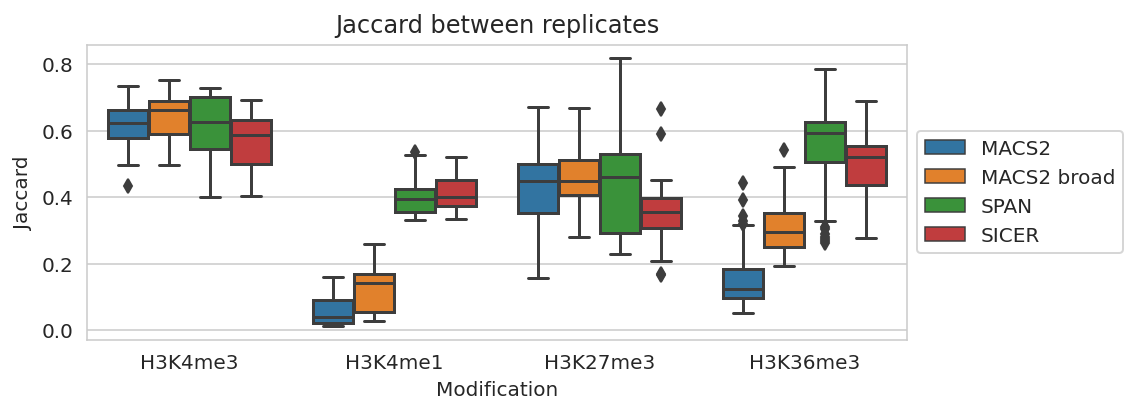

In [61]:
plt.figure(figsize=(8, 3))
plt.title('Jaccard between replicates')
g_results = sns.boxplot(data=rj, x='Modification', y='Jaccard', hue='Tool', 
                        order=MODIFICATIONS,
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        # capsize=.05, errwidth=2, edgecolor="black",
                        )
# sns.boxplot(data=rj, x='Modification', y='Jaccard', hue='Tool')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

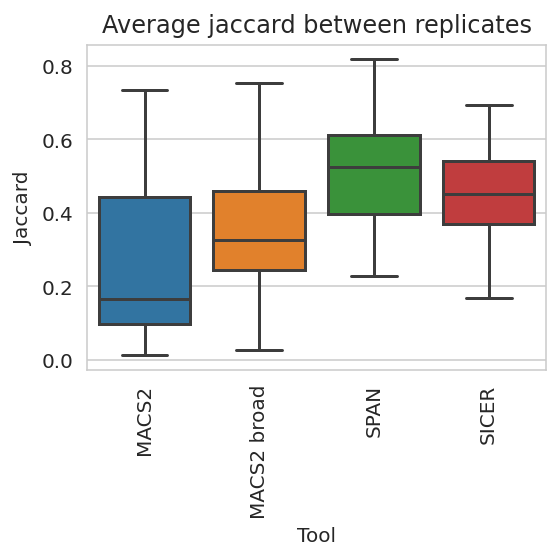

In [62]:
plt.figure(figsize=(4, 4))
plt.title(f'Average jaccard between replicates')
g_result = sns.boxplot(data=rj, x='Tool', y='Jaccard', showfliers=False,
                       order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
g_result.axes.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'overlap.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

# IDR between replicates

In [70]:
def compute_reps_idr(df_peaks, modifications, rank):
    reps_idr = pd.DataFrame(columns=['modification', 'tool', 'rep1', 'rep2', 'peaks1', 'peaks2',
                                     'idr_loaded_peaks1', 'idr_loaded_peaks2', 'idr_peaks', 'idr_loaded_peaks', 'idr_percentage'
                                     ], dtype=object)

    tf = tempfile.mktemp()
    tf1 = tempfile.mktemp()
    tf2 = tempfile.mktemp()

    tools = df_peaks['name'].unique()
    for m in tqdm(modifications):
        print(m)
        tm = df_peaks[(df_peaks['modification'] == m)]
        reps = list(sorted(set(tm['replicate'])))
        for tool in tools:
            for i in range(len(reps)):
                for j in range(i + 1, len(reps)):
                    rep1, rep2 = reps[i], reps[j]
                    t1 = tm[(tm['name'] == tool) & (tm['replicate'] == rep1)]
                    t2 = tm[(tm['name'] == tool) & (tm['replicate'] == rep2)]
                    if len(t1) == 0 or len(t2) == 0:
                        continue
                    try:
                        file1 = t1['file'].values[0]
                        file2 = t2['file'].values[0]
                        print(tool, file1, file2)
                        peaks1 = t1['peaks'].values[0]
                        peaks2 = t2['peaks'].values[0]
                        # Process SICER peaks, add missing 8th column, as -log10 qvalue
                        if tool == 'SICER':
                            sf1 = pd.read_csv(file1, sep='\t', header=None)
                            sf1[8] = -np.log10(sf1[7])
                            sf1.to_csv(tf1, sep='\t', index=None, header=False)
                            file1 = tf1
                            sf2 = pd.read_csv(file2, sep='\t', header=None)
                            sf2[8] = -np.log10(sf2[7])
                            sf2.to_csv(tf2, sep='\t', index=None, header=False)
                            file2 = tf2
                        ! idr --input-file-type bed --rank {rank} --samples {file1} {file2} 2>&1 | tee {tf}
                        with open(tf) as f:
                            idr_out = f.read()
                        # print('IDR OUT', tf, idr_out)
                        lp1, lp2 = re.findall('Number of reported peaks - (\\d+)/(\\d+)', idr_out)[0]
                        lp1, lp2 = int(lp1), int(lp2)
                        ip, ilp, iperc = re.findall('Number of peaks passing IDR cutoff of 0.05 - (\\d+)/(\\d+) \\(([\\d\\.]+)', idr_out)[0]
                        ip, ilp, iperc = int(ip), int(ilp), float(iperc)
                        print(m, tool, rep1, rep2, peaks1, peaks2, lp1, lp2, ip, ilp, iperc)
                        reps_idr.loc[len(reps_idr)] = \
                            (m, tool, rep1, rep2, peaks1, peaks2, lp1, lp2, ip, ilp, iperc)
                    except Exception as e:
                        # raise e
                        # print(e)
                        pass  # Ignore errors for now
    return reps_idr

In [ ]:
reps_idr = compute_reps_idr(dfa, MODIFICATIONS, 8)
reps_idr.sample(5)

  0%|          | 0/4 [00:00<?, ?it/s]

H3K4me3
MACS2 /home/jetbrains/data/2022_comparative_analysis/macs2/H1_H3K4me3_1_1_q0.05_peaks.narrowPeak /home/jetbrains/data/2022_comparative_analysis/macs2/H1_H3K4me3_2_1_q0.05_peaks.narrowPeak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.00 0.36 0.81 0.94]
Number of reported peaks - 18398/18398 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 9199/18398 (50.0%)

H3K4me3 MACS2 1_1 2_1 30674 21265 18398 18398 9199 18398 50.0
MACS2 /home/jetbrains/data/2022_comparative_analysis/macs2/H1_H3K4me3_1_1_q0.05_peaks.narrowPeak /home/jetbrains/data/2022_comparative_analysis/macs2/H1_H3K4me3_3_1_q0.05_peaks.narrowPeak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-pac

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.96 0.87 0.10 0.01]
Number of reported peaks - 2366/2366 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/2366 (0.0%)

H3K4me3 SICER 1_1 2_1 19069 16702 2366 2366 0 2366 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_1_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_3_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.01 0.65 0.11 0.10]
Number of reported peaks - 1397/1397 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/1397 (0.0%)

H3K4me3 SICER 1_1 3_1 19069 16987 1397 1397 0 1397 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_1_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_5_2-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.20 0.78 0.10 0.46]
Number of reported peaks - 1963/1963 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/1963 (0.0%)

H3K4me3 SICER 1_1 5_2 19069 16867 1963 1963 0 1963 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_1_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_7_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [1.00 0.96 0.72 0.01]
Number of reported peaks - 426/426 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/426 (0.0%)

H3K4me3 SICER 1_1 7_1 19069 20345 426 426 0 426 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_1_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_8_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.32 0.65 0.55 0.03]
Number of reported peaks - 3064/3064 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/3064 (0.0%)

H3K4me3 SICER 1_1 8_1 19069 22611 3064 3064 0 3064 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_2_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_3_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.00 1.08 0.90 0.01]
Number of reported peaks - 1434/1434 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/1434 (0.0%)

H3K4me3 SICER 2_1 3_1 16702 16987 1434 1434 0 1434 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_2_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_5_2-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.07 0.54 0.10 0.16]
Number of reported peaks - 2129/2129 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/2129 (0.0%)

H3K4me3 SICER 2_1 5_2 16702 16867 2129 2129 0 2129 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_2_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_7_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.03 0.64 0.10 0.21]
Number of reported peaks - 410/410 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/410 (0.0%)

H3K4me3 SICER 2_1 7_1 16702 20345 410 410 0 410 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_2_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_8_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.29 0.61 0.10 0.04]
Number of reported peaks - 3053/3053 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/3053 (0.0%)

H3K4me3 SICER 2_1 8_1 16702 22611 3053 3053 0 3053 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_3_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_5_2-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.05 0.68 0.10 0.36]
Number of reported peaks - 1336/1336 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/1336 (0.0%)

H3K4me3 SICER 3_1 5_2 16987 16867 1336 1336 0 1336 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_3_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_7_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.13 0.41 0.10 0.99]
Number of reported peaks - 362/362 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 249/362 (68.8%)

H3K4me3 SICER 3_1 7_1 16987 20345 362 362 249 362 68.8
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_3_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_8_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [1.13 0.81 0.14 0.01]
Number of reported peaks - 1584/1584 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/1584 (0.0%)

H3K4me3 SICER 3_1 8_1 16987 22611 1584 1584 0 1584 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_5_2-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_7_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.44 0.42 0.13 0.21]
Number of reported peaks - 358/358 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/358 (0.0%)

H3K4me3 SICER 5_2 7_1 16867 20345 358 358 0 358 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_5_2-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_8_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.48 0.96 0.41 0.04]
Number of reported peaks - 3493/3493 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/3493 (0.0%)

H3K4me3 SICER 5_2 8_1 16867 22611 3493 3493 0 3493 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_7_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me3_8_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.08 0.73 0.10 0.01]
Number of reported peaks - 437/437 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/437 (0.0%)

H3K4me3 SICER 7_1 8_1 20345 22611 437 437 0 437 0.0
H3K4me1
MACS2 /home/jetbrains/data/2022_comparative_analysis/macs2/H1_H3K4me1_2_1_q0.05_peaks.narrowPeak /home/jetbrains/data/2022_comparative_analysis/macs2/H1_H3K4me1_3_1_q0.05_peaks.narrowPeak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxve

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 1/1 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 1/1 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_2_1-W200-G600-islands-summary-FD

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 1/1 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 1/1 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_2_1-W200-G600-islands-summary-FD

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 1/1 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 1/1 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_2_1-W200-G600-islands-summary-FD

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_2_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_5_1-W200-G600-islands-summary

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 1/1 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 1/1 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_2_1-W200-G600-islands-summary-FD

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 1/1 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 1/1 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_3_1-W200-G600-islands-summary-FD

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 1/1 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 1/1 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_3_1-W200-G600-islands-summary-FD

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 2/2 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 2/2 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_3_1-W200-G600-islands-summary-FD

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 1/1 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 1/1 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_3_1-W200-G600-islands-summary-FD

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 4/4 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 4/4 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_3_1-W200-G600-islands-summary-FD

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 3/3 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 3/3 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_4_1-W200-G600-islands-summary-FD

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 2/2 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 2/2 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_4_1-W200-G600-islands-summary-FD

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 1/1 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 1/1 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_4_1-W200-G600-islands-summary-FD

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 2/2 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 2/2 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_4_1-W200-G600-islands-summary-FD

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 4/4 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 4/4 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_4_2-W200-G600-islands-summary-FD

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 3/3 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 3/3 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_4_2-W200-G600-islands-summary-FD

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 2/2 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 2/2 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_4_2-W200-G600-islands-summary-FD

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 2/2 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 2/2 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_4_3-W200-G600-islands-summary-FD

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 1/1 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 1/1 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_4_3-W200-G600-islands-summary-FD

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 1/1 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 1/1 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K4me1_5_1-W200-G600-islands-summary-FD

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Number of reported peaks - 2/2 (100.0%)

Number of peaks passing IDR cutoff of 1.0 - 2/2 (100.0%)

/home/jetbrains/miniconda3/envs/pubtrends/bin/idr --input-file-type bed --rank 8 --samples /tmp/tmpdoxomnfc /tmp/tmpwk_pnh89
Traceback (most recent call last):
  File "/home/jetbrains/miniconda3/envs/pubtrends/bin/idr", line 10, in <module>
    idr.idr.main()
  File "/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/idr/idr.py", line 857, in main
    raise ValueError(error_msg)
ValueError: Peak files must contain at least 20 peaks post-merge
Hint: Merged peaks were written to the output file
H3K27me3
MACS2 /home/jetbrains/data/2022_comparative_analysis/macs2/H1_H3K27me3_1_2_q0.05_peaks.narrow

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.09 0.20 0.10 0.99]
Number of reported peaks - 107/107 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 80/107 (74.8%)

H3K27me3 SICER 1_2 2_1 20129 5882 107 107 80 107 74.8
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_1_2-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_2_2-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.09 0.20 0.10 0.99]
Number of reported peaks - 107/107 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 80/107 (74.8%)

H3K27me3 SICER 1_2 2_2 20129 6739 107 107 80 107 74.8
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_1_2-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_4_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.04 0.20 0.10 0.99]
Number of reported peaks - 138/138 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 83/138 (60.1%)

H3K27me3 SICER 1_2 4_1 20129 30276 138 138 83 138 60.1
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_1_2-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_5_2-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.03 0.20 0.10 0.99]
Number of reported peaks - 126/126 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 69/126 (54.8%)

H3K27me3 SICER 1_2 5_2 20129 19902 126 126 69 126 54.8
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_1_2-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_5_3-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.15 0.20 0.10 0.99]
Number of reported peaks - 127/127 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 108/127 (85.0%)

H3K27me3 SICER 1_2 5_3 20129 19437 127 127 108 127 85.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_1_2-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_6_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.08 0.26 0.10 0.99]
Number of reported peaks - 152/152 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 108/152 (71.1%)

H3K27me3 SICER 1_2 6_1 20129 15022 152 152 108 152 71.1
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_1_2-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_7_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.08 0.26 0.10 0.99]
Number of reported peaks - 152/152 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 108/152 (71.1%)

H3K27me3 SICER 1_2 7_1 20129 23436 152 152 108 152 71.1
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_2_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_2_2-W200-G600-islands-summary-FDR0.01
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_min

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.06 0.29 0.10 0.99]
Number of reported peaks - 252/252 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 153/252 (60.7%)

H3K27me3 SICER 2_1 2_2 5882 6739 252 252 153 252 60.7
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_2_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_4_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.21 0.84 0.10 0.01]
Number of reported peaks - 249/249 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/249 (0.0%)

H3K27me3 SICER 2_1 4_1 5882 30276 249 249 0 249 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_2_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_5_2-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.00 0.26 0.16 0.99]
Number of reported peaks - 246/246 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 134/246 (54.5%)

H3K27me3 SICER 2_1 5_2 5882 19902 246 246 134 246 54.5
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_2_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_5_3-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.21 0.84 0.10 0.01]
Number of reported peaks - 249/249 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/249 (0.0%)

H3K27me3 SICER 2_1 5_3 5882 19437 249 249 0 249 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_2_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_6_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.00 0.38 0.10 0.99]
Number of reported peaks - 247/247 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 121/247 (49.0%)

H3K27me3 SICER 2_1 6_1 5882 15022 247 247 121 247 49.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_2_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_7_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.08 0.32 0.10 0.99]
Number of reported peaks - 245/245 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 151/245 (61.6%)

H3K27me3 SICER 2_1 7_1 5882 23436 245 245 151 245 61.6
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_2_2-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_4_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.09 0.88 0.10 0.01]
Number of reported peaks - 306/306 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/306 (0.0%)

H3K27me3 SICER 2_2 4_1 6739 30276 306 306 0 306 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_2_2-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_5_2-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.20 0.91 0.10 0.01]
Number of reported peaks - 307/307 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/307 (0.0%)

H3K27me3 SICER 2_2 5_2 6739 19902 307 307 0 307 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_2_2-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_5_3-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [1.67 0.87 0.21 0.01]
Number of reported peaks - 309/309 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/309 (0.0%)

H3K27me3 SICER 2_2 5_3 6739 19437 309 309 0 309 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_2_2-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_6_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.09 0.88 0.10 0.01]
Number of reported peaks - 306/306 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/306 (0.0%)

H3K27me3 SICER 2_2 6_1 6739 15022 306 306 0 306 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_2_2-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_7_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.39 0.46 0.10 0.01]
Number of reported peaks - 305/305 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/305 (0.0%)

H3K27me3 SICER 2_2 7_1 6739 23436 305 305 0 305 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_4_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_5_2-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.03 0.58 0.10 0.99]
Number of reported peaks - 1241/1241 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 653/1241 (52.6%)

H3K27me3 SICER 4_1 5_2 30276 19902 1241 1241 653 1241 52.6
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_4_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_5_3-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [1.13 0.62 0.98 0.01]
Number of reported peaks - 1213/1213 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/1213 (0.0%)

H3K27me3 SICER 4_1 5_3 30276 19437 1213 1213 0 1213 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_4_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_6_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.09 0.49 0.10 0.99]
Number of reported peaks - 831/831 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 493/831 (59.3%)

H3K27me3 SICER 4_1 6_1 30276 15022 831 831 493 831 59.3
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_4_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_7_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.09 0.55 0.10 0.99]
Number of reported peaks - 834/834 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 494/834 (59.2%)

H3K27me3 SICER 4_1 7_1 30276 23436 834 834 494 834 59.2
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_5_2-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_5_3-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.42 0.48 0.24 0.04]
Number of reported peaks - 1456/1456 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/1456 (0.0%)

H3K27me3 SICER 5_2 5_3 19902 19437 1456 1456 0 1456 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_5_2-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_6_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.22 0.69 0.10 0.30]
Number of reported peaks - 828/828 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/828 (0.0%)

H3K27me3 SICER 5_2 6_1 19902 15022 828 828 0 828 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_5_2-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_7_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [1.72 0.81 0.10 0.01]
Number of reported peaks - 810/810 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/810 (0.0%)

H3K27me3 SICER 5_2 7_1 19902 23436 810 810 0 810 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_5_3-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_6_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.03 0.56 0.10 0.99]
Number of reported peaks - 824/824 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 441/824 (53.5%)

H3K27me3 SICER 5_3 6_1 19437 15022 824 824 441 824 53.5
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_5_3-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_7_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.21 0.91 0.10 0.01]
Number of reported peaks - 813/813 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/813 (0.0%)

H3K27me3 SICER 5_3 7_1 19437 23436 813 813 0 813 0.0
SICER /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_6_1-W200-G600-islands-summary-FDR0.01 /home/jetbrains/data/2022_comparative_analysis/sicer/H1_H3K27me3_7_1-W200-G600-islands-summary-FDR0.01


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [0.01 0.91 0.10 0.21]
Number of reported peaks - 796/796 (100.0%)

Number of peaks passing IDR cutoff of 0.05 - 0/796 (0.0%)

H3K27me3 SICER 6_1 7_1 15022 23436 796 796 0 796 0.0
H3K36me3
MACS2 /home/jetbrains/data/2022_comparative_analysis/macs2/H1_H3K36me3_2_2_q0.05_peaks.narrowPeak /home/jetbrains/data/2022_comparative_analysis/macs2/H1_H3K36me3_3_1_q0.05_peaks.narrowPeak
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_m

In [ ]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=reps_idr, x='modification', hue='tool', y='idr_percentage',
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR %')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=reps_idr, x='modification', hue='tool', y='idr_peaks',
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       showfliers=False
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=reps_idr, x='modification', hue='tool', y='idr_loaded_peaks',
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR loaded peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 2))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    t = reps_idr[reps_idr['modification'] == m]
    g_results = sns.scatterplot(data=t,
                                x='idr_peaks', y='idr_percentage',
                                hue='tool',
                                alpha=0.8,
                                ax=ax,
                                )
    ax.title.set_text(m)
    if i != 0:
        ax.set_ylabel(None)
    if i != 3:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Consistency analysis between different tools

In [64]:
import tempfile

tools_overlap = pd.DataFrame(columns=['modification', 'rep', 'tool1', 'tool2',
                                      'peaks1', 'peaks2', 'length1', 'length2',
                                       'overlap1', 'overlap2', 'intersect'], dtype=object)

tools = list(sorted(set(dfa['name'])))
for m in tqdm(MODIFICATIONS):
    print(m)
    tm = dfa.loc[dfa['modification'] == m]
    reps = list(sorted(set(tm['replicate'])))
    for rep in reps:
        for i in range(len(tools)):
            for j in range(i + 1, len(tools)):
                tool1, tool2 = tools[i], tools[j]
                t1 = tm.loc[(tm['name'] == tool1) & (tm['replicate'] == rep)]
                t2 = tm.loc[(tm['name'] == tool2) & (tm['replicate'] == rep)]
                if len(t1) == 0 or len(t2) == 0:
                    continue
                m = t1['modification'].values[0]
                file1 = sorted_file(t1['file'].values[0])
                peaks1 = t1['peaks'].values[0]
                length1 = bedl(file1).sum()
                file2 = sorted_file(t2['file'].values[0])
                peaks2 = t2['peaks'].values[0]
                length2 = bedl(file2).sum()
                tf = tempfile.mktemp()
                ! bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
                overlap1 = lines(tf)
                ! bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
                overlap2 = lines(tf)
                ! bedtools intersect -a {file1} -b {file2} -wo > {tf}
                intersection_length = int(last_col(tf).sum())
                tools_overlap.loc[len(tools_overlap)] = \
                    (m, rep, tool1, tool2, peaks1, peaks2, length1, length2,
                     overlap1, overlap2, intersection_length)

  0%|          | 0/4 [00:00<?, ?it/s]

H3K4me3
H3K4me1
H3K27me3
H3K36me3


## Overlap between tools

In [65]:
to = pd.DataFrame(columns=['modification', 'replicate', 'tool1', 'tool2', 'overlap'], dtype=object)
for _, row in tools_overlap.iterrows():
    m = row['modification']
    rep = row['rep']
    tool1 = row['tool1']
    tool2 = row['tool2']
    peaks1 = row['peaks1']
    peaks2 = row['peaks2']
    overlap1 = row['overlap1']
    overlap2 = row['overlap2']
    to.loc[len(to)] = (m, rep, tool1, tool2, d(overlap1, peaks1))
    to.loc[len(to)] = (m, rep, tool2, tool1, d(overlap2, peaks2))
to

,modification,replicate,tool1,tool2,overlap
0,H3K4me3,1_1,MACS2,MACS2 broad,1.000000
1,H3K4me3,1_1,MACS2 broad,MACS2,0.951963
2,H3K4me3,1_1,MACS2,SICER,0.993382
3,H3K4me3,1_1,SICER,MACS2,0.935288
4,H3K4me3,1_1,MACS2,SPAN,0.994523
...,...,...,...,...,...
379,H3K36me3,7_1,SICER,MACS2 broad,0.876408
380,H3K36me3,7_1,MACS2 broad,SPAN,0.914119
381,H3K36me3,7_1,SPAN,MACS2 broad,0.808977
382,H3K36me3,7_1,SICER,SPAN,0.977722


H3K4me3
H3K4me1
H3K27me3
H3K36me3


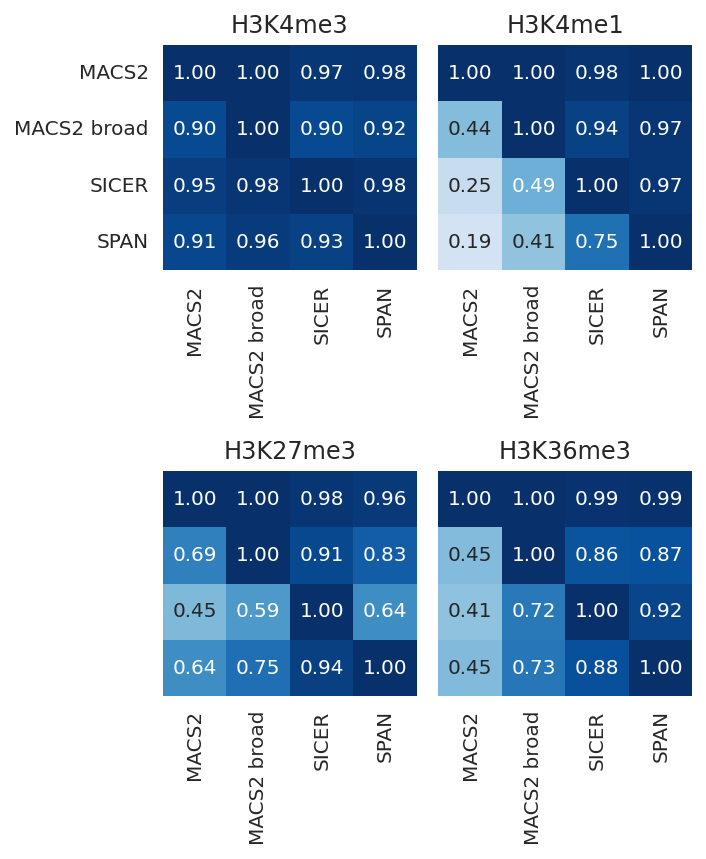

In [66]:
from math import ceil

#Heatmaps
fig = plt.figure(figsize=(5, 8))
for i, m in enumerate(MODIFICATIONS):
    print(m)
    tom = to[to['modification'] == m].groupby(['tool1', 'tool2'])['overlap'].mean().reset_index().copy()
    tomp = tom.pivot(index='tool1', columns='tool2', values='overlap').fillna(1.0)
    ax = plt.subplot(3, int(ceil(len(MODIFICATIONS) / 3)), i + 1)
    sns.heatmap(tomp, ax=ax, vmin=0, vmax=1, annot=True, fmt='.2f',
                yticklabels=(i == 0 or i == 7), cbar=False, cmap='Blues')
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(m)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'overlap_tools.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

## Jaccard between tools

In [67]:
tj = pd.DataFrame(columns=['modification', 'replicate', 'tool1', 'tool2', 'jaccard'], dtype=object)
for _, row in tools_overlap.iterrows():
    m = row['modification']
    rep = row['rep']
    tool1 = row['tool1']
    tool2 = row['tool2']
    length1 = row['length1']
    length2 = row['length2']
    intersection = row['intersect']
    jaccard = d(intersection, length1 + length2 - intersection)
    tj.loc[len(tj)] = (m, rep, tool1, tool2, jaccard)

H3K4me3
H3K4me1
H3K27me3
H3K36me3


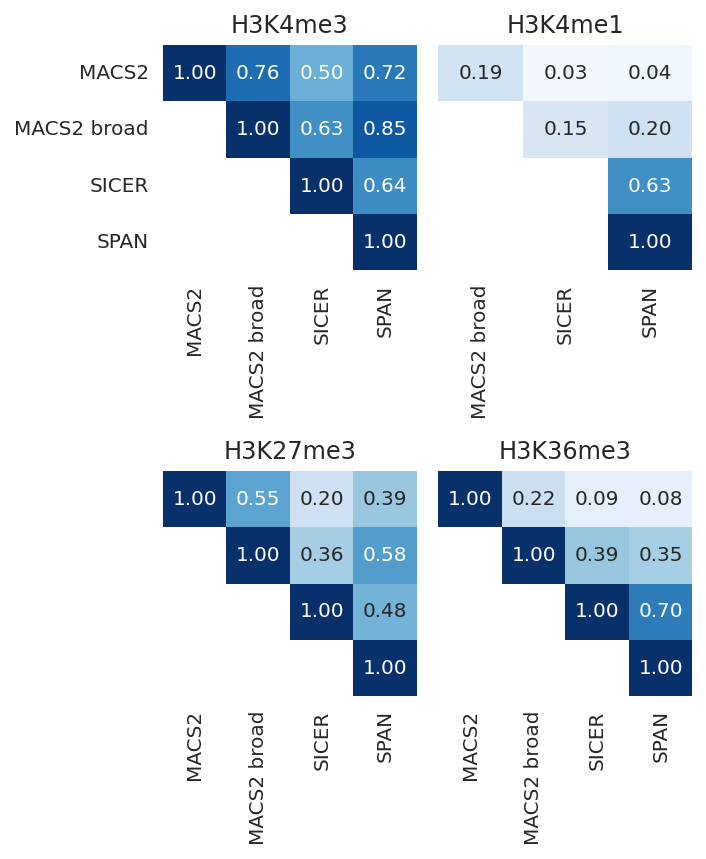

In [68]:
#Heatmaps
fig = plt.figure(figsize=(5, 8))

for i, m in enumerate(MODIFICATIONS):
    print(m)
    tjm = tj[tj['modification'] == m].copy()
    for t in tools:
        tjm.loc[len(tjm)] = (m, 'rep', t, t, 1.0)
    tjm = tjm.groupby(['tool1', 'tool2'])['jaccard'].mean().reset_index().copy()
    tjmp = tjm.pivot(index='tool1', columns='tool2', values='jaccard')
    ax = plt.subplot(3, int(ceil(len(MODIFICATIONS) / 3)), i + 1)
    sns.heatmap(tjmp, ax=ax, vmin=0, vmax=1, annot=True, fmt='.2f',
                yticklabels=(i == 0 or i == 7), cbar=False, cmap='Blues')
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(m)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_tools.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()